# AAV Simulation Workflow

This notebook uses **openiex** in two stages:

1. **Rough Parameter Fitting**  
   We tune our model to roughly reproduce a Cytiva step-gradient prescreening profile [1].

2. **Model Application**  
   Using those fitted parameters, we then explore new conditions to showcase openiex’s ability to predict chromatographic outcomes.

---

[1]: Cytiva. *Effective separation of full and empty rAAV capsids by anion exchange*.  
    https://www.cytivalifesciences.com/en/us/knowledge-center/Effective-separation-of-full-and-empty-rAAV-capsids-by-anion-exchange  


## Prerequisites

Clone the repo and install in editable mode so Python can import it:

```git clone https://github.com/you/openiex.git``` <br>
```cd openiex```  <br>
```pip install -e . ```

In [1]:
from openiex import (
    SystemConfig, Ion, Protein, Inert, ExchangeSystem,
    Method, validate_method,
    initialize_state, load_state,
    method_duration, run_simulation, resume_simulation,
    save_simulation, load_simulation, 
    plot_single_species, plot_chromatogram, plot_column_snapshot,
    SimulationResult
)
import numpy as np
from pathlib import Path

## System & Model Setup

Below we define the chromatographic system we’ll simulate. We’ve chosen parameters based on the conditions used in Cytiva's publicly available data. 2 mL Tricorn 5/100 packed with Capto™ Q ImpRes, with AAV charge heterogeneity oversimplified into three “species” (empty, partial, full capsids).

- **Resin & Column**  
  Capto Q ImpRes in a 2 mL Tricorn 5/100 (bed height = 0.102 m, radius = 0.0025 m).

- **Sample Load**  
  1 × 10¹² cp/mL resin, split into empty/partial/full in a 4:1:5 ratio (for simplicity).

- **Charge Heterogeneity**  
  Real AAV preparations have multiple charge variants; here we model only three populations to demo the concept and tune our SMA parameters (`σ`, `ν`, `K_eq`, `k_ads`) until the elution profile qualitatively matches the Cytiva prescreening data.

- **Buffer Compositions**  
  - **Load** (Load): 1 × 10¹² cp/mL, 20 mM BTP, 2 mM MgCl₂  
  - **Buffer A** (Equilibration & Wash): 20 mM BTP, 2 mM MgCl₂  
  - **Buffer B** (Elution): 20 mM BTP, 2 mM MgCl₂, 250 mM NaOAc  

- **Elution Protocol**  
  1. Equilibrate with Buffer A
  2. Load for 1 CV at 2 mL/min  
  3. Wash with A for 5 CV at 2 mL/min
  4. Step gradient in 5 % NaOAc increments (3 CV each) at 2 mL/min  

**Note:** We omit BTP as an inert species in the solver to speed up computation—it contributes to neither binding nor UV/cond signal in this proof-of-concept.  
**In practice**, you’d first enrich or separate the empty, partial, and full capsid fractions (for example by ultracentrifugation or preparative AEX), then characterize each fraction’s binding behavior through breakthrough curves and linear-gradient elutions to fit the model parameters before running more complex simulations.  


In this next block we:

1. **Define mobile-phase ions**  
   - **Cl⁻** (from MgCl₂ equilibration) and **Ac⁻** (from NaOAc elution) with their dispersion coefficients and molar conductivities.

2. **Define binding species**  
   - **em**: empty capsid  
   - **pa**: partially full capsid  
   - **fu**: full capsid  
   Each with a steric capacity `σ`, cooperativity `ν`, and UV extinction coefficients.  We split the 1×10¹² cp/mL load into these three populations.

3. **Define inert salts**  
   - **Mg²⁺** and **Na⁺** for conductivity signal only (they do not participate in binding).

4. **Configure the column**  
   - Capto Q ImpRes, 2 mL Tricorn 5/100 (0.102 m height × 0.0025 m radius), ionic capacity Λ = 0.165 mol/L, void fractions εᵢ = 0.35, εₚ = 0.40, Nz = 20.

5. **Set equilibrium parameters**  
   - We tune `K_eq` and `k_ads` for each ion-ion and protein–ion pair (`Cl−` and `Ac−`) until our simulated elution roughly matches the Cytiva prescreening profile.
   
 #### Parameter Units Reference

Below are the units for every key parameter used in this notebook—listed once to keep things concise:

- **Species properties**  
  - `D`: axial dispersion coefficient, **m²/s**  
  - `K_d`: pore accessibility, **dimensionless (0–1)**  
  - `unit`: concentration unit, one of **“M”** or **“particles/mL”**  
  - `sigma`: steric hindrance (binding sites per molecule), **sites per molecule**  
  - `nu`: cooperativity exponent (ions exchanged per molecule), **sites per molecule**  
  - `mol_cond`: molar conductivity, **S·cm²/mol**  
  - `ext_coeff_260`, `ext_coeff_280`: extinction at 260/280 nm, **AU·M⁻¹·cm⁻¹**

- **Ion-exchange system**  
  - `bed_height`: column bed height, **m**  
  - `column_radius`: column radius, **m**  
  - `Lambda`: ionic capacity, **mol/L-resin**  
  - `epsilon_i`, `epsilon_p`: interstitial/intraparticle void fractions, **dimensionless**  
  - `Nz`: number of axial discretization points, **integer**

- **Method (chromatogram) parameters**  
  - `flow_rate_mL_min`: flow rate, **mL/min**  
  - `duration_CV`: step duration in total column volumes (CV) with no interstitial void correction, **CV**  
  - `start_B`, `end_B`: fraction of Buffer B, **dimensionless (0–1)**


In [3]:
ions = {
    "Cl-": Ion("Cl-", D=1e-10, mol_cond=76.3),    # MgCl2 equilibration
    "Ac-": Ion("Ac-", D=1e-10, mol_cond=40.9),    # NaOAc elution
}

proteins = {
    "em": Protein("em", D=5e-12, sigma=1e5, nu=7,
                  unit="particles/mL",
                  ext_coeff_260=3.72e6, ext_coeff_280=6.61e6,
                  K_d=1),
    "pa": Protein("pa", D=5e-12, sigma=1e5, nu=9,
                  unit="particles/mL",
                  ext_coeff_260=1.92e7, ext_coeff_280=1.51e7,
                  K_d=1),
    "fu": Protein("fu", D=5e-12, sigma=1e5, nu=10,
                  unit="particles/mL",
                  ext_coeff_260=3.47e7, ext_coeff_280=2.35e7,
                  K_d=1),
}

inert = {
    "Mg2+": Inert("Mg2+", D=7e-10, mol_cond=53.0),
    "Na+":  Inert("Na+",  D=1.33e-9, mol_cond=50.1),
}

# Column configuration
config = SystemConfig(
    bed_height   = 0.102,
    column_radius= 0.0025,
    Lambda       = 0.165,
    epsilon_i    = 0.35,
    epsilon_p    = 0.40,
    Nz           = 20,
)

# Build the system
system = ExchangeSystem(ions, proteins, inert, config)

# Tune equilibria for each protein/ion pair
system.set_equilibrium("Cl-", "Ac-", ln_K_eq_val=0,    ln_k_ads_val=5)
system.set_equilibrium("em",  "Cl-", ln_K_eq_val=7.1,  ln_k_ads_val=14)
system.set_equilibrium("em",  "Ac-", ln_K_eq_val=-4.0, ln_k_ads_val=14)
system.set_equilibrium("pa",  "Cl-", ln_K_eq_val=9.7,  ln_k_ads_val=19)
system.set_equilibrium("pa",  "Ac-", ln_K_eq_val=-4.6, ln_k_ads_val=19)
system.set_equilibrium("fu",  "Cl-", ln_K_eq_val=12.4, ln_k_ads_val=22)
system.set_equilibrium("fu",  "Ac-", ln_K_eq_val=-3.5, ln_k_ads_val=22)

# Quick sanity check
system.check_equilibria()

All required equilibria are defined.


In [4]:
# Buffers as described above
buffers = {
    "Load": {"Cl-": 0.004, "Ac-": 0.0, "em": 4e11, "pa": 1e11, "fu": 5e11, "Mg2+": 0.002, "Na+": 0}, 
    "A": {"Cl-": 0.004, "Ac-": 0.0, "em": 0.0, "pa": 0, "fu": 0.0, "Mg2+": 0.002, "Na+": 0},
    "B": {"Cl-": 0.004, "Ac-": 0.25, "em": 0.0, "pa": 0, "fu": 0.0, "Mg2+": 0.002, "Na+": 0.25},
}

# 1-CV load, 5-CV Buffer A wash, 5%B step elution from 0-40%B
blocks = [
    {"buffer_A": "Load", "buffer_B": "B", "start_B": 0.0, "end_B": 0.0, "duration_CV": 1, "flow_rate_mL_min": 2.0},
    {"buffer_A":"A","buffer_B":"B",
     "start_B":0.0, "end_B":0.0,
     "duration_CV": 5,
     "flow_rate_mL_min": 2
    },
    *[
        {"buffer_A":"A","buffer_B":"B",
         "start_B": i * 0.05,
         "end_B"  : i * 0.05,
         "duration_CV": 3,
         "flow_rate_mL_min": 2
         }
        for i in range(1, int(0.4 / 0.05) + 1)
    ]
]

# Build and validate chromatography method
method = Method(buffers, blocks)
validate_method(method, system) # Outputs nothing if OK

In [9]:
# Define Buffer A-equilibrated system, binding sites fully occupied by Cl-
initial_conditions = {
    "Cl-": {"C": 0.004, "Q": system.config.Lambda},
    "Mg2+": {"C": 0.002}
}
y0 = initialize_state(initial_conditions, system)

# Calculate simulation time 
t_final = method_duration(method, system)
t_eval = np.linspace(0, t_final, 1000)
 
# Run simulation
res: SimulationResult = run_simulation(
    y0, t_eval, method, system, 
    integrator='BDF', 
    rtol=1e-4,
    atol=1e-7,
    max_step=0.02,
    first_step=1e-3,
)

Simulating:   0%|          | 0/1802.128359325279 [00:00<?, ?s/s]

In [5]:
# Set save directory
results_dir = Path.cwd().parent / "results"

In [12]:
# Save simulation
save_simulation(
    "cytiva_prescreening_example", res, results_dir=results_dir
)

Simulation saved: /usr/home/jkeeley/openiex/results/cytiva_prescreening_example.npz and /usr/home/jkeeley/openiex/results/cytiva_prescreening_example.json


In [6]:
# Load simulation
prescreening = load_simulation("cytiva_prescreening_example", results_dir=results_dir)

### Chromatogram + Fraction Analysis

Below we use our `plot_chromatogram` call to visualize elution, using `fractions` to tabulate how much **empty**, **partial**, and **full** capsid comes off in each peak, with user-defined bounds. `data_point` can be used to view absorbances and conductivity at a particular x location.

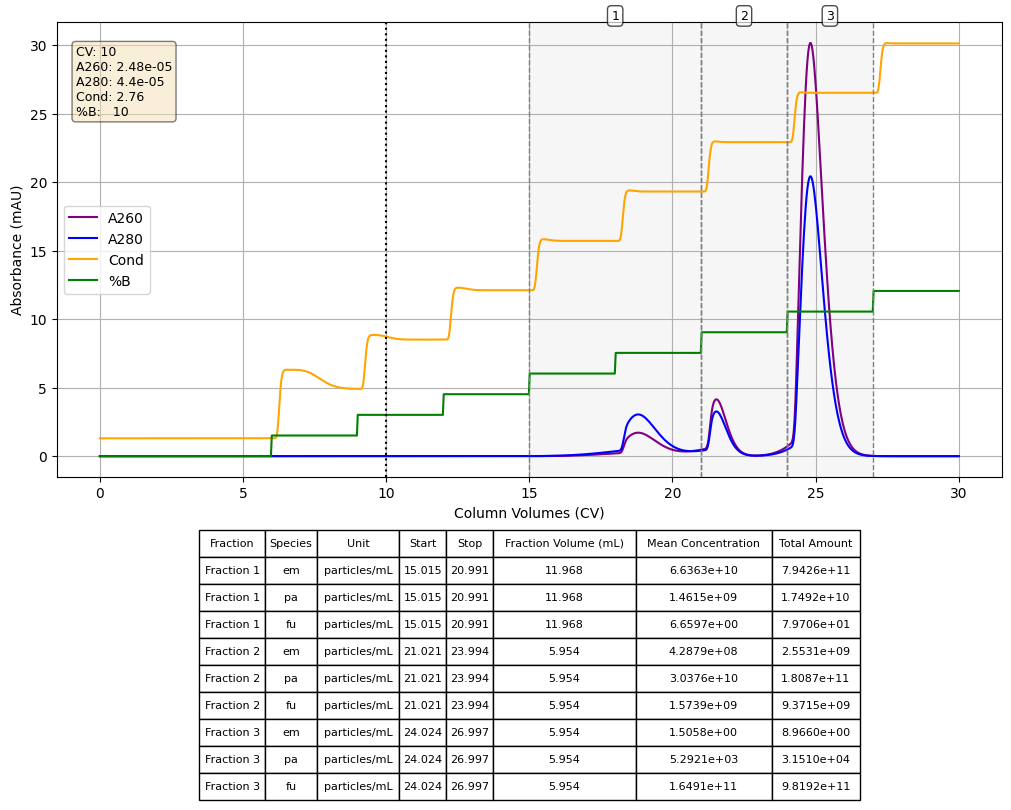

In [7]:
plot_chromatogram(prescreening, 
                  x_axis='CV', 
                  y_axis='UV',
                  fractions=[(15,21),(21,24),(24,27)],
                  frac_species=["em", "pa", "fu"],
                  data_point=10
                 )

### Inspecting Individual Species Elution

We can zoom in on each capsid population’s outlet profile to see exactly where—and how sharply—it elutes. The `plot_single_species` function plots the mobile‐ (or bound-) phase concentration of one species versus the chosen x-axis (here, CV).

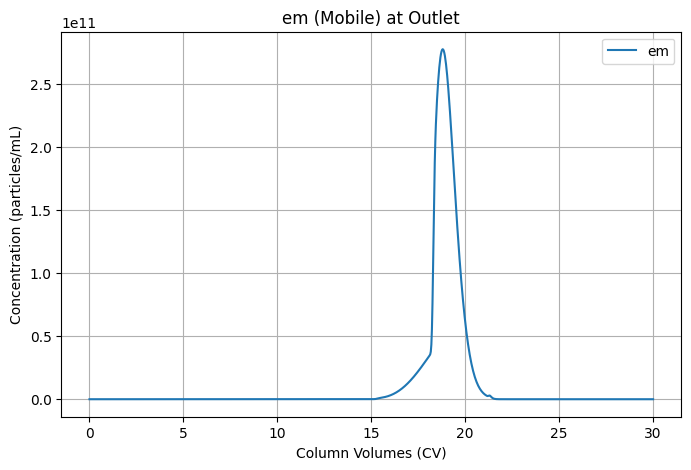

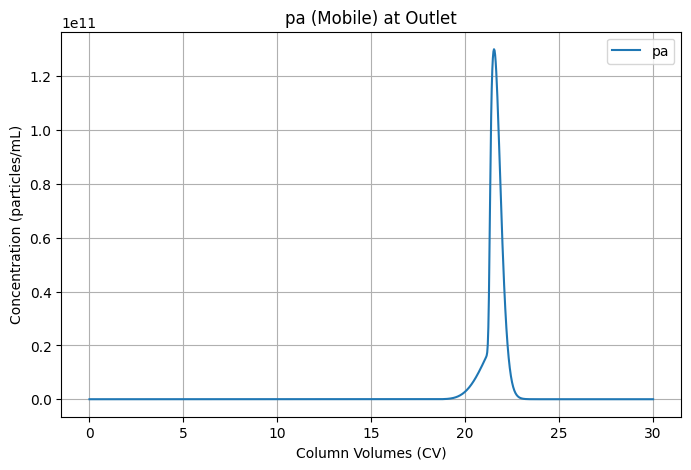

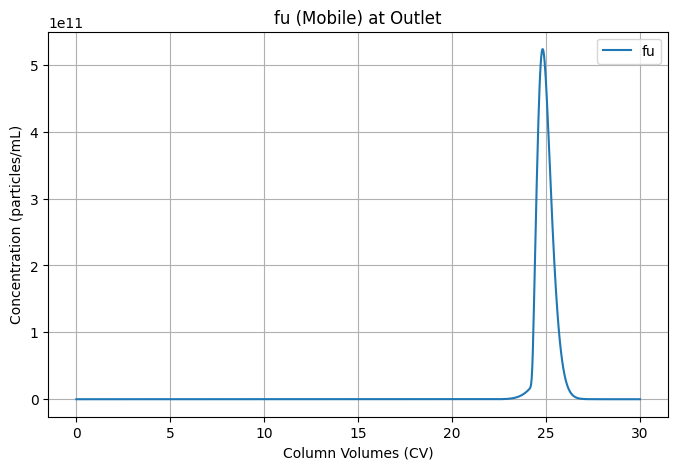

In [8]:
plot_single_species(prescreening, "em", x_axis='CV')
plot_single_species(prescreening, "pa", x_axis='CV')
plot_single_species(prescreening, "fu", x_axis='CV')

### Visualizing Species Migration Through the Column

With `plot_column_snapshot` we can step through the entire column profile of a single species—either its mobile-phase concentration or bound-phase loading—at successive time (or CV) points. A slider lets you scrub through the run and watch, for example:

- **Salt spikes** triggering a rapid reshuffling of protein between mobile and bound phases  
- **Band movement** from the column inlet down to the outlet  
- **Concentration clustering** near the top of the column with low loads, for example

This interactive view is invaluable for spotting effects like fronting/tailing, incomplete binding, breakthrough, and binding rates.

In [10]:
plot_column_snapshot(prescreening, "em", x_axis="CV")

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='Column Volumes (CV)', max=2…

### Two-Step Elution

After the fine-grained prescreening to pinpoint each capsid’s elution window, Cytiva applies a targeted two-step gradient to collect the empty and full fractions in bulk.  We can reproduce that same protocol in **openiex**:

- **Load**  
  - 1 CV sample load at 2 mL/min  

- **Wash**  
  - 5 CV Buffer A at 2 mL/min  
  
- **Elution Step 1**  
  - 20 CV 25% Buffer B at 2 mL/min 
  
- **Elution Step 2**  
  - 5 CV 40% Buffer B at 2 mL/min  

In [27]:
blocks = [
    {"buffer_A": "Load", "buffer_B": "B", "start_B": 0.0, "end_B": 0.0, "duration_CV": 1, "flow_rate_mL_min": 2.0},
    {"buffer_A": "A", "buffer_B": "B", "start_B": 0.0, "end_B": 0.0, "duration_CV": 5, "flow_rate_mL_min": 2.0},
    {"buffer_A": "A", "buffer_B": "B", "start_B": 0.25, "end_B": 0.25, "duration_CV": 20, "flow_rate_mL_min": 2.0},
    {"buffer_A": "A", "buffer_B": "B", "start_B": 0.4, "end_B": 0.4, "duration_CV": 5, "flow_rate_mL_min": 2.0},
]

# Build and validate chromatography method
method = Method(buffers, blocks)
validate_method(method, system)

In [32]:
t_final = method_duration(method, system)
t_eval = np.linspace(0, t_final, 1000)

res: SimulationResult = run_simulation(
    y0, t_eval, method, system, 
    integrator='BDF', 
    rtol=1e-4,
    atol=1e-7,
    max_step=0.02,
    first_step=1e-3,
)

Simulating:   0%|          | 0/1862.199304636121 [00:00<?, ?s/s]

In [40]:
# Save simulation
save_simulation(
    "cytiva_two_step", res, results_dir=results_dir
)

Simulation saved: /usr/home/jkeeley/openiex/results/cytiva_two_step.npz and /usr/home/jkeeley/openiex/results/cytiva_two_step.json


In [41]:
# Load simulation
two_step = load_simulation("cytiva_two_step", results_dir=results_dir)

### Two-Step Fraction Purity & Recovery

Using our `analyze_fraction` output, we can directly quantify how many empty vs. full capsids appear in each fraction:

- **Empty‐Capsid Fraction (25 % B, 20 CV)**  
  - Collected **≃ 8e+11** empty capsids, **≃ 2e+11** partially full capsids
  - Lost **≃ 1.6e+10** full capsids (≃ 1.6% loss)

- **Full‐Capsid Fraction (40 % B, 5 CV)**  
  - Collected **≃ 9.8e+11** full capsids  
  - Co‐eluted **≃ 0** empty capsids, **≃ 0** partially full capsids (≃ 100% purity)

These numbers show the trade-off between **yield** and **purity**. You can tweak the step conditions or explore continuous gradients in **openiex** to optimize your system.

**Note:** This degree of separation is clearly unrealistic and is a result of the oversimplified 3-species system. Though a more accurate system can be developed with more detailed experimental data, this simplified model still provides valuable insights into how process parameters impact separation outcomes.

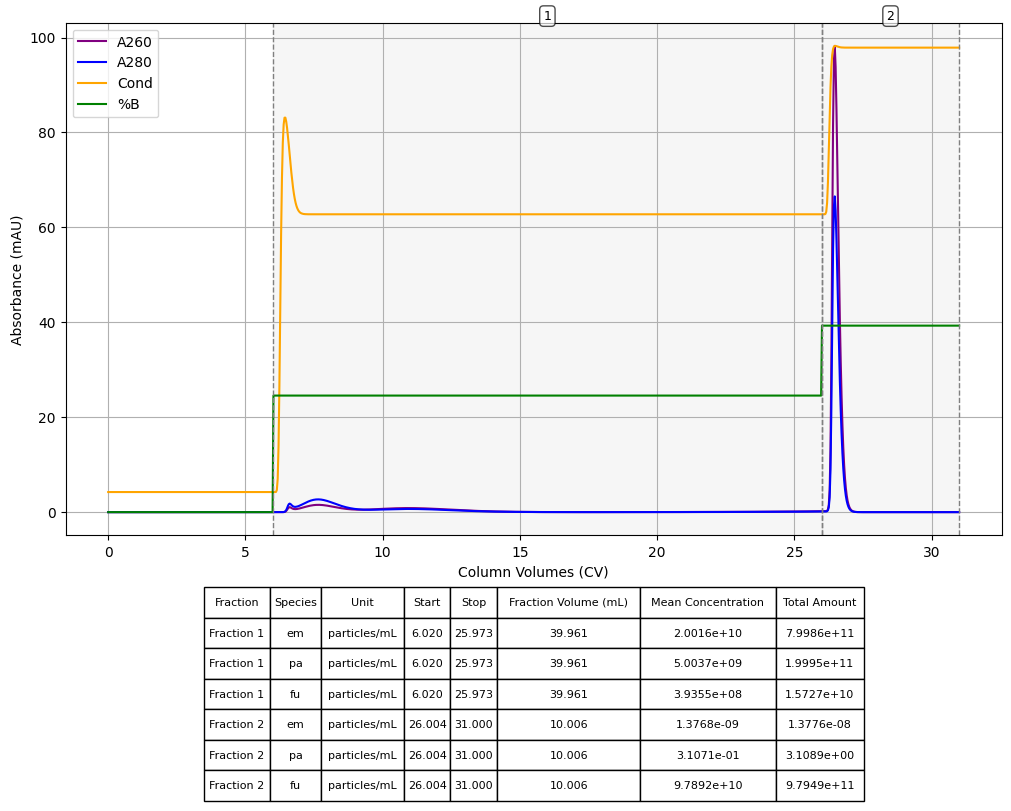

In [42]:
plot_chromatogram(two_step, x_axis='CV', y_axis='UV',
                  fractions=[(6,26),(26,31)],
                  frac_species=["em", "pa", "fu"],
                 )